In [33]:
import numpy as np
import tensorflow as tf
from keras.datasets import cifar10
from keras.layers import Dense, Dropout, Activation, Flatten, Lambda, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D, merge
from keras.engine import Input, Model
from keras.optimizers import SGD
from keras.callbacks import Callback, LearningRateScheduler, ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
import keras.backend as K
import json
import time

import matplotlib.pyplot as plt
from keras.utils import plot_model

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_44 (InputLayer)            (None, 32, 32, 3)     0                                            
____________________________________________________________________________________________________
conv2d_225 (Conv2D)              (None, 32, 32, 4)     16          input_44[0][0]                   
____________________________________________________________________________________________________
conv2d_223 (Conv2D)              (None, 32, 32, 4)     16          input_44[0][0]                   
____________________________________________________________________________________________________
conv2d_226 (Conv2D)              (None, 32, 32, 6)     222         conv2d_225[0][0]                 
__________________

C:\Users\KHM\AppData\Local\conda\conda\envs\py35\lib\site-packages\ipykernel_launcher.py:33: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(4, (1, 1), activation="relu", padding="same", data_format="channels_last", kernel_initializer="he_normal", strides=(1, 1))`
C:\Users\KHM\AppData\Local\conda\conda\envs\py35\lib\site-packages\ipykernel_launcher.py:36: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(4, (1, 1), activation="relu", padding="same", data_format="channels_last", kernel_initializer="he_normal", strides=(1, 1))`
C:\Users\KHM\AppData\Local\conda\conda\envs\py35\lib\site-packages\ipykernel_launcher.py:38: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(4, (3, 3), activation="relu", padding="same", data_format="channels_last", kernel_initializer="he_normal", strides=(1, 1))`
C:\Users\KHM\AppData\Local\conda\conda\envs\py35\lib\site-packages\ipykernel_launcher.py:41: UserWarning: Update your `Conv2D` call to the Keras 2 A

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 50s - loss: 1.7884 - acc: 0.3839 - val_loss: 1.4460 - val_acc: 0.4873
Epoch 2/20
50000/50000 [==============================] - 49s - loss: 1.3635 - acc: 0.5228 - val_loss: 1.2766 - val_acc: 0.5513
Epoch 3/20
50000/50000 [==============================] - 50s - loss: 1.2695 - acc: 0.5566 - val_loss: 1.2298 - val_acc: 0.5723
Epoch 4/20
50000/50000 [==============================] - 50s - loss: 1.2049 - acc: 0.5801 - val_loss: 1.2238 - val_acc: 0.5694
Epoch 5/20
50000/50000 [==============================] - 51s - loss: 1.1689 - acc: 0.5924 - val_loss: 1.2200 - val_acc: 0.5694
Epoch 6/20
50000/50000 [==============================] - 50s - loss: 1.1348 - acc: 0.6045 - val_loss: 1.1186 - val_acc: 0.6118
Epoch 7/20
50000/50000 [==============================] - 50s - loss: 1.0935 - acc: 0.6201 - val_loss: 1.1300 - val_acc: 0.6064
Epoch 8/20
50000/50000 [==============================

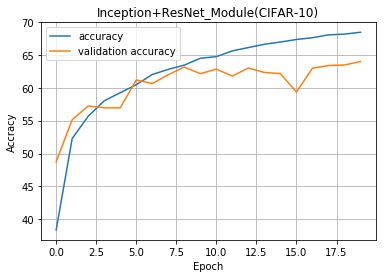

validation accuracy :  0.6397


In [47]:
nb_classes = 10

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# reorder dimensions for tensorflow
x_train = np.transpose(x_train.astype('float32') / 255., (0, 1, 2, 3))
x_test = np.transpose(x_test.astype('float32') / 255., (0, 1, 2, 3))
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

# we reduce # filters by factor of 8 compared to original inception-v4
nb_filters_reduction_factor = 8

#%%time

img_rows, img_cols = 32, 32
img_channels = 3

# in original inception-resnet-v2, these are 5, 10, 5, respectively
num_A_blocks = 1
num_B_blocks = 1
num_C_blocks = 1

inputs = Input(shape=(img_rows, img_cols, img_channels))

a = Convolution2D(32//nb_filters_reduction_factor, 1, 1, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(inputs)
    
b = Convolution2D(32//nb_filters_reduction_factor, 1, 1, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(inputs)
b = Convolution2D(32//nb_filters_reduction_factor, 3, 3, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(b)
    
c = Convolution2D(32//nb_filters_reduction_factor, 1, 1, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(inputs)
c = Convolution2D(48//nb_filters_reduction_factor, 3, 3, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(c)
c = Convolution2D(64//nb_filters_reduction_factor, 3, 3, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(c)

d = AveragePooling2D((1, 1), strides=(1, 1), border_mode='valid', dim_ordering='tf')(inputs)
    
x = merge([a, b, c, d], mode='concat', concat_axis=-1)

x = Activation('relu')(x)

#x = AveragePooling2D(pool_size=(4, 4), strides=(1, 1), border_mode='valid', dim_ordering='tf')(x)
x = Dropout(0.5)(x)
x = Flatten()(x)

predictions = Dense(nb_classes, activation='softmax')(x)

model = Model(input=inputs, output=predictions)

model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

plot_model(model, to_file='Inception_ResNet_model_CIFAR.png', show_shapes=True, show_layer_names=True)


batch_size = 128
nb_epoch = 20

his= model.fit(x_train, y_train, 
                        batch_size=batch_size, nb_epoch=nb_epoch, verbose=1,
                        validation_data=(x_test, y_test), shuffle=True,
                        callbacks=[])

# acc
acc = his.history["acc"]
val_acc = his.history["val_acc"]

acc_List = []
valacc_List = []

for i in acc:
    acc_List.append(i*100)

for i in val_acc:
    valacc_List.append(i*100)

plt.grid(True)
plt.plot(acc_List, label = 'accuracy')
plt.plot(valacc_List, label = 'validation accuracy')
plt.ylabel('Accracy')
plt.xlabel('Epoch')
plt.title(r'Inception+ResNet_Module(CIFAR-10)')
plt.legend()
plt.show()
print("validation accuracy : ", val_acc[-1])
